# Air Pollution NO2 Data Analysis

## README

### Overview
This notebook conducts a comprehensive analysis of nitrogen dioxide (NO₂) pollution using Sentinel-5P data, with a focus on Ethiopia (Addis Ababa) and Iraq (Baghdad). It covers the full workflow, including data retrieval, preprocessing, aggregation, and visualisation.

### Objective
The aim is to assess spatial and temporal patterns in NO₂ levels as a proxy for air pollution and economic activity. 

### Workflow
The notebook is structured into three main parts:
1. **Data Download** – Retrieves NO₂ data from Google Earth Engine (Sentinel-5P).
2. **Data Processing** – Fills missing values, clips to boundaries, and aggregates to mesh/grid.
3. **Visualisation** – Produces spatial plots and animated GIFs for temporal dynamics.

### Outputs
- **Filled NO₂ Data**: Exported in TIFF format for spatial analyses.
- **Aggregated NO₂ Values**: Saved in GeoParquet format by mesh for efficiency.
- **Visual Animations**: NO₂ variation over time shown in GIF format.


## 0 Prepare Packages

Cancel the comment to install all the packages and libraries needed.

In [ ]:
# ! pip install rasterio matplotlib rasterstats ipynbname imageio tqdm
# ! pip install numpy==1.24.4

## 1 Download Data

In this chapter, NO2 pollution data from [Google Earth Engine Sentinel 5P](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S5P_NRTI_L3_NO2) is downloaded, for both Ethiopia and Iraq in country level.

From related literature, we chose **tropospheric_NO2_column_number_density** as the proxy for NO2 concentration level.

### 1.1 Custom Functions

Custom function to generate desired time period of NOx data.

In [1]:
import pandas as pd
from typing import List

import ee
ee.Authenticate() # For the first Initialization, individual API is needed to log into Google Earth Engine
ee.Initialize()

# Function: generate desired time period of NO2 data  
def specific_date(start_date: str, end_date: str, time_resolution: str = 'D') -> List[str]:
    """
    Generate a list of dates within specified time period and resolution.

    Parameters:
    - start_date: str
        Start date, format: 'YYYY-MM-DD'.
    - end_date: str
        End date, format: 'YYYY-MM-DD'.
    - time_resolution: str
        Time resolution (e.g., 'D' for daily, 'W' for weekly, 'M' for monthly). Default is 'D'.
    
    Return:
    - dates(list): List of date strings marking the ends of each time segment, format: 'YYYY-MM-DD'.
    
    """
    dates = (
        pd.date_range(start_date, end_date, freq = time_resolution)
        .strftime('%Y-%m-%d')
        .tolist()
    )
    return dates


Request tasks to download in Google Drive.

In [2]:
# Function: download NO2 data
def download_no2_country(country_name: str, dates: list):
    """
    Request NO2 data download from Earth Engine for a specified country and time period

    Parameters:
    - country_name: str
        Name of the target country. Must match the format used by Earth Engine.
    - dates: list
        List containing the desired time range, (e.g., [start_date, end_date]).

    Return:
    - None. Sends a/multiple request(s) to Earth Engine to initiate data download.
        Exported files are saved under a folder named 'NO2_<country_name>' in first-level Google Drive directory.
        Each exported .tiff file is named using its starting date.
    """
    
    countries = ee.FeatureCollection('USDOS/LSIB_SIMPLE/2017')
    country = countries.filter(ee.Filter.eq('country_na', country_name)).geometry()

    n_dates = len(dates)

    for i in range(n_dates-1):

        date_start, date_end = dates[i], dates[i+1]

        no2 = (ee.ImageCollection('COPERNICUS/S5P/NRTI/L3_NO2')
            .select('tropospheric_NO2_column_number_density')
            .filterDate(date_start, date_end)
            .mean())

        task = ee.batch.Export.image.toDrive(
            image=no2,
            description=f'{country_name}_NO2_{date_start}_{date_end}',
            folder=f'NO2_{country_name}',
            fileNamePrefix=f'{country_name}_NO2_{date_start}',
            region=country,
            scale=1000,
            maxPixels=1e13
        )

        try:
            task.start()
            print(f'{country_name}: The export task for {date_start} is ongoing, please check the results in Google Drive.')
        except Exception as e:
            print(f'Fail to sumbit task: {e}')

### 1.2 Call and Download Data

In [ ]:
dates = specific_date('2018-07-11', '2025-5-20')
# len(dates) # 2507

# Download Ethiopia Data
download_no2_country('Ethiopia', dates)

# Download Iraq Data
download_no2_country('Iraq', dates)

## 2 Data Process Pipeline

This chapter processes the NO2 data downloaded in Chapter 1 through the following steps:

- **(1) Filling Missing Value**: Spot the missing values in raster and replenish them using iterative checking, using **mean** of the neighbour raster as the replenish value.

- **(2) Clipping to Region**: Clipping the data to the interested area, and output the filled raster.

- **(3) Aggregation**: Import the generated mesh and aggregate the raster to the mesh level.

Step 2 and 3 are realised by selecting and aggregating the data within the (synthesised) mesh grid. 

Output at the end of the process:

- The processed data will be exported in format of GeoParquet (*.gpq*), which is an open, efficient and modern file format designed for storing geospatial vector data.

*Note: Currently since the official mesh for the two regions (Baghdad and Addis Ababa) are not provided, so we synthesised the mesh to establish the workflow.*

### 2.1 Fill Missing Data

In this chapter, missing data in each raster is filled using the neighbour data, and the filled raster is saved in a new seperate folder: *Ethiopia_NO2_filled* and *Iraq_NO2_filled*

#### 1) Define Custom Functions

Define functions to read and iteratively fill missing data.

In [2]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path

# Global Variables
notebook_dir = Path(r'D:/Projects/MSc_Group_Project/no2_economicactivity_gdp/src')
base_dir = Path(r'D:/Projects/MSc_Group_Project/no2_economicactivity_gdp/data')
demo_dir = Path(r'D:/Projects/MSc_Group_Project/no2_economicactivity_gdp/demo-data')

# Function: read tiff files
def read_tiff(filename):
    with rasterio.open(filename) as src:
        band = src.read(1)          # first band
        profile = src.profile       # meta data
        nodata_value = src.nodata   # get nodata (missing)

    return src, band, profile, nodata_value


# iterative missing data interpolate
from scipy.ndimage import generic_filter

# Function: using neighbour average mean as interpolation value
def fill_nan_with_mean(arr):
    center = arr[len(arr) // 2]
    if np.isnan(center):
        mean = np.nanmean(arr)
        return mean if not np.isnan(mean) else np.nan
    return center

# Function: iteratively interpolate missing values
def iterative_fill(data, max_iter=10, window_size=9):
    """
    Parameters:
    -----------
    max_iteration: control the max iteration value
    window_size: the smoothing window of the moving average, set as odd number to avoid raster shifting
    
    """
    filled = data.copy()
    for i in range(max_iter):
        prev_nan = np.isnan(filled).sum()
        filled = generic_filter(filled, function=fill_nan_with_mean, size=window_size, mode='nearest')
        new_nan = np.isnan(filled).sum()
        # print(f"Iteration {i+1}: remaining NaNs = {new_nan}")
        if new_nan == 0 or new_nan == prev_nan:
            break
    return filled


#### 2) Fill Missing Data in Ethiopia

It took over 8 hours to run the following cell. So after processed the following cell, comment it. 

In [ ]:
os.chdir(base_dir) 
eth_tiff_path = os.path.join('Ethiopia_NO2')
eth_tiffs = [f for f in os.listdir(eth_tiff_path) if f.lower().endswith('.tif')]
r_eth_paths = [os.path.join(eth_tiff_path, f) for f in eth_tiffs] # relative path
# print(r_eth_paths)

# Create a folder to save filled data
output_dir = 'Ethiopia_NO2_filled'

# Create folder saving filled data
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Loop to process each tiff
for index, tiff_path in enumerate(r_eth_paths):

    date = eth_tiffs[index].split('_')[2].split('.')[0]
    # Trace progress
    print(f"currently working on: {index+1}, {date}" ) 

    # Detect non-valid data
    file_size_mb = os.path.getsize(tiff_path) / (1024 * 1024)
    if file_size_mb < 1:
        print(f"File size {file_size_mb:.2f}KB < 1MB, skipping {date} file.")
        continue 

    # Read raster data
    src, band, profile, nodata_value = read_tiff(tiff_path)
    if nodata_value is not None:    # replace no_data as np.nan
        band = np.where(band == nodata_value, np.nan, band)

    # Missing Value replacement
    band_filled = iterative_fill(band, max_iter=10, window_size=9)

    # Save filled data
    output_file = 'Ethiopia_NO2_filled/'+'Ethiopia_NO2_' + date + '_filled.tif'
    with rasterio.open(output_file, 'w', **profile) as dst:
        filled_band = np.where(np.isnan(band_filled), nodata_value, band_filled)        # replace np.nan with nodata
        dst.write(filled_band.astype(profile['dtype']), 1)
    

#### 3) Fill Missing Data in Iraq

After processed the following cell, comment it.

In [ ]:
os.chdir(base_dir) 
iraq_tiff_path = os.path.join('Iraq_NO2')
iraq_tiffs = [f for f in os.listdir(iraq_tiff_path) if f.lower().endswith('.tif')]
r_iraq_paths = [os.path.join(iraq_tiff_path, f) for f in iraq_tiffs] # relative path

# Create a folder to save filled data
output_dir = 'Iraq_NO2_filled'
country = "Iraq"

# Create folder saving filled data
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
# Loop to process each tiff
for index, tiff_path in enumerate(r_iraq_paths):

    date = iraq_tiffs[index].split('_')[2].split('.')[0]
    # Trace progress
    print(f"currently working on: {index+1}, {date}" ) 

    # Detect non-valid data
    file_size_mb = os.path.getsize(tiff_path) / (1024 * 1024)
    if file_size_mb < 1:
        print(f"File size {file_size_mb:.2f}KB < 1MB, skipping {date} file.")
        continue 

    # Read raster data
    src, band, profile, nodata_value = read_tiff(tiff_path)
    if nodata_value is not None:    # replace no_data as np.nan
        band = np.where(band == nodata_value, np.nan, band)

    # Missing Value replacement
    band_filled = iterative_fill(band, max_iter=10, window_size=9)

    # Save filled data
    output_file = country + '_NO2_filled/' + country + '_NO2_' + date + '_filled.tif'
    with rasterio.open(output_file, 'w', **profile) as dst:
        filled_band = np.where(np.isnan(band_filled), nodata_value, band_filled) # replace np.nan with nodata
        dst.write(filled_band.astype(profile['dtype']), 1)

#### 4) Demonstrate Purpose

Use *Ethiopia_NO2_2018-07-12.tif* file as an exmaple to show what this missing data process loop do in each iteration.

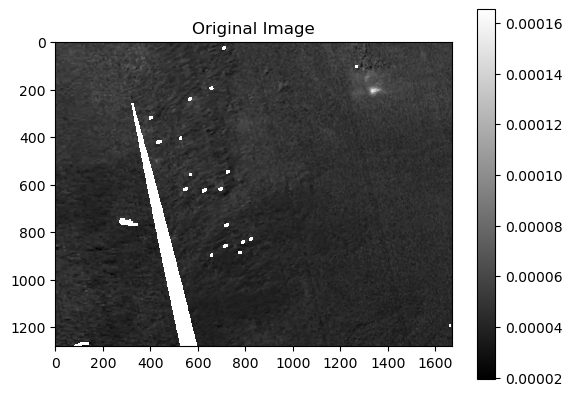

In [4]:
# Set working directory
import os
from pathlib import Path

# reset working directory to current script path
os.chdir(demo_dir)          

# original image
src, band, profile, nodata_value = read_tiff('Ethiopia_NO2_2018-07-12.tif')

plt.imshow(band, cmap='gray') # 'gray'
plt.title("Original Image")
plt.colorbar()
plt.show()

C:\Users\87383\AppData\Local\Temp\ipykernel_111256\947287286.py:29: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(arr)


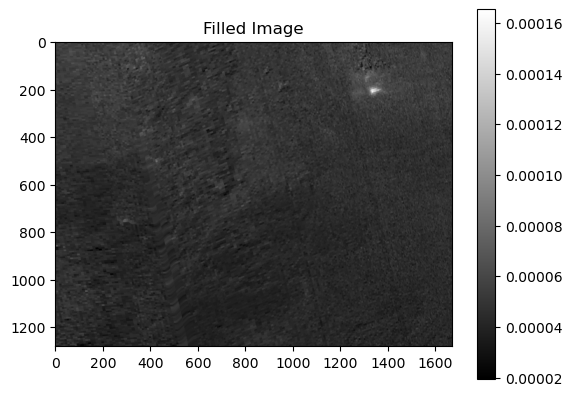

In [5]:
# filled image
band_filled = iterative_fill(band, max_iter=10, window_size=9)

plt.imshow(band_filled, cmap='gray')
plt.title("Filled Image")
plt.colorbar()
plt.show()

### 2.2 Aggregate Based on Hexagon Mesh

#### 1) Define Custom functions

In [4]:
import geopandas as gpd
from rasterstats import zonal_stats
import numpy as np
import matplotlib.pyplot as plt
import os

# Function: Aggregate data within each hexagon
def aggregate_to_mesh(hex_mesh, tiff_path):

    stats = zonal_stats(hex_mesh, tiff_path, stats=["mean"], nodata=np.nan)
    hex_mesh["no2_mean"] = [s["mean"] for s in stats]

    return hex_mesh

# shift to notebook direction
os.chdir(demo_dir)

# Load the mesh
hex_addis_gdf = gpd.read_parquet("addis_ababa_mesh_5km.gpq")
hex_baghdad_gdf = gpd.read_parquet("baghdad_mesh_5km.gpq")

# Change working directory to read filled
os.chdir(base_dir)

#### 2) Aggregate Ethiopia - Addis Ababa

In [ ]:
# Aggregate Ethiopia - Addis Ababa
eth_no2_filled_path = os.path.join('Ethiopia_NO2_filled')
eth_filled_tiffs = [f for f in os.listdir(eth_no2_filled_path) if f.lower().endswith('.tif')]
r_eth_filled_paths = [os.path.join(eth_no2_filled_path, f) for f in eth_filled_tiffs] # relative path
# print(r_eth_filled_paths)

# Create a folder to save filled data
output_dir = 'addis_ababa_no2_mesh'
city = 'addis_ababa'

# Create folder saving filled data
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [ ]:
for index, tiff_path in enumerate(r_eth_filled_paths):

    date = eth_filled_tiffs[index].split('_')[2].split('.')[0]
    print(f"currently working on: {index+1}, {date}")

    try:
        new_hex_mesh = aggregate_to_mesh(hex_addis_gdf, tiff_path)
        output_file = os.path.join(output_dir, f'{city}_hex_{date}.parquet')
        new_hex_mesh.to_parquet(output_file)

    except Exception as e:
        print(f"Error processing {tiff_path} at index {index}: {e}")
        print("Skipping to next file...")
        continue


#### 3) Aggregate Iraq - Baghdad

In [ ]:
# Aggregate Iraq - Baghdad
iraq_no2_filled_path = os.path.join('Iraq_NO2_filled')
iraq_filled_tiffs = [f for f in os.listdir(iraq_no2_filled_path) if f.lower().endswith('.tif')]
r_iraq_filled_paths = [os.path.join(iraq_no2_filled_path, f) for f in iraq_filled_tiffs] # relative path
# print(r_iraq_filled_paths)

# Create a folder to save filled data
output_dir = 'baghdad_no2_mesh'
city = 'baghdad'

# Create folder saving filled data
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for index, tiff_path in enumerate(r_iraq_filled_paths):

    date = iraq_filled_tiffs[index].split('_')[2].split('.')[0]
    # Trace progress
    print(f"currently working on: {index+1}, {date}" ) 

    new_hex_mesh = aggregate_to_mesh(hex_baghdad_gdf, tiff_path)

    # Save as Parquet
    output_file = os.path.join(output_dir, f'{city}_hex_{date}.parquet')
    new_hex_mesh.to_parquet(output_file)

#### 4) Demonstrate Purpose

Show aggregated value in Addis Ababa.

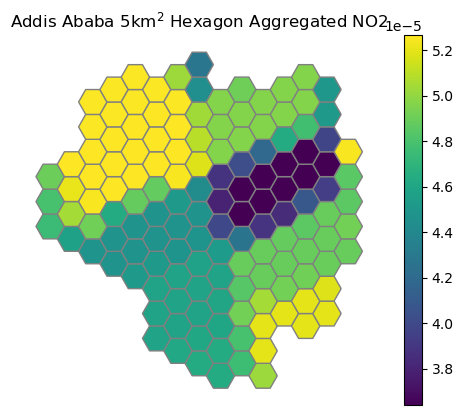

In [5]:
# shift to demo direction
os.chdir(demo_dir)   
hex_gdf = gpd.read_parquet('addis_ababa_mesh_5km.gpq')
 
raster_path = 'Ethiopia_NO2_2018-07-12_filled.tif'

# using mean as representitive value
stats = zonal_stats(hex_gdf, raster_path, stats=["mean"], nodata=np.nan)  # other alternatives: "std", "max", "min", "sum"
hex_gdf["mean"] = [s["mean"] for s in stats]

# visual
hex_gdf.plot(column="mean", edgecolor="grey", legend=True)
plt.title("Addis Ababa 5km$^2$ Hexagon Aggregated NO2")
plt.axis("off")
plt.show()

Show aggregated value in Baghdad.

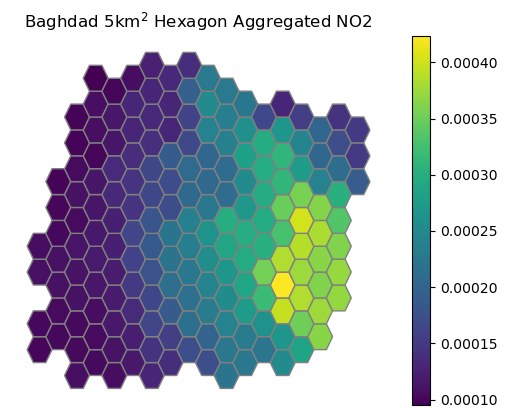

In [6]:
# shift to demo direction
os.chdir(demo_dir)   
hex_gdf = gpd.read_parquet('baghdad_mesh_5km.gpq')
 
raster_path = 'Iraq_NO2_2018-07-12_filled.tif'

# using mean as representitive value
stats = zonal_stats(hex_gdf, raster_path, stats=["mean"], nodata=np.nan)  # other alternatives: "std", "max", "min", "sum"
hex_gdf["mean"] = [s["mean"] for s in stats]

# visual
hex_gdf.plot(column="mean", edgecolor="grey", legend=True)
plt.title("Baghdad 5km$^2$ Hexagon Aggregated NO2")
plt.axis("off")
plt.show()

## 3 Data Visualisation

This chapter is used to generate a dynatmic figure, to show how the feature distribution change with time.

Note:

- In the coloration system, percentile clipping and contrast streching method is uesd to imporve the visual effects of the image.

- In this chapter, the dynamic distribution of NO2 is generated, in format of GIF. 

### 3.1 Define Custom Functions

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegWriter
from matplotlib.colors import LinearSegmentedColormap, Normalize
from pathlib import Path
from tqdm import tqdm
import os

def generate_animation(tif_dir: str, out_gif_name: str = "timeseries", fps = 12, start_tiff = 0, end_tiff = 200):
    """
    Parameters
    ----------
    tif_dir: str
        tiffs path
    out_gif_name: str
        output gif name, without suffix
    fps: int
        frames per second
    number_tiffs: int
        number of tiffs in the animation
    """
    
    # Set interal parameters
    colors        = ["blue", "cyan", "yellow", "red"] # colors in the raster
    cmap          = LinearSegmentedColormap.from_list("custom_map", colors)    # color mapping
    percent_clip  = 0.8                              # percentage clipped to emphasise visualization
    title_fmt     = "Date: {date}"                   # figure format

    # Read and sort tiffs
    tif_files = sorted(tif_dir.glob("*.tif"))[start_tiff:end_tiff]     # sort by names
    dates     = [f.stem for f in tif_files]       # use file names as label

    # Determine global vin/vmax
    vals = []
    for tif in tqdm(tif_files, desc="Scanning percentiles"):
        with rasterio.open(tif) as src:
            arr = src.read(1)
            # filter nodata
            if src.nodata is not None:
                arr = arr[arr != src.nodata]
            # filter nan
            arr = arr[~np.isnan(arr)]
            vals.append(arr)
    vals = np.hstack(vals)
    vmin = np.percentile(vals, percent_clip)
    vmax = np.percentile(vals, 100 - percent_clip)

    # print(f"Total valid pixels: {vals.size}")
    # print(f"vmin = {vmin}, vmax = {vmax}, Δ = {vmax - vmin}")
    norm = Normalize(vmin=vmin, vmax=vmax, clip=True)  # clip the outlier values to boudnary color

    # Read the first tif to determine the plotting range
    with rasterio.open(tif_files[0]) as src:
        first = src.read(1, masked=True)
    
    # Define updata function
    def update(i):
        with rasterio.open(tif_files[i]) as src:
            arr = src.read(1, masked=True)
        img.set_data(arr)               
        txt.set_text(title_fmt.format(date=dates[i]))
        return img, txt

    # Matplotlib animation
    fig, ax = plt.subplots(figsize=(6, 6))
    img = ax.imshow(first, cmap=cmap, norm=norm)
    cbar = plt.colorbar(img, ax=ax, fraction=0.046, pad=0.04, label="NO₂ (percent-clipped)")
    txt  = ax.text(0.02, 0.96, "", transform=ax.transAxes,
                color="white", fontsize=11, ha="left", va="top",
                bbox=dict(facecolor="black", alpha=0.3, pad=2, lw=0))
    ax.axis("off")

    anim = FuncAnimation(fig, update, frames=len(tif_files),
                        interval=1000 / fps, blit=True)
    
    # Create an output folder
    output_dir = 'animation_output'
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    anim.save(output_dir+'\\'+out_gif_name+'.gif', writer=PillowWriter(fps=fps))
    plt.show()


### 3.2 Generate Animations

#### 1) NO2 Distributions in Ethiopia

Scanning percentiles: 100%|██████████| 200/200 [00:19<00:00, 10.50it/s]


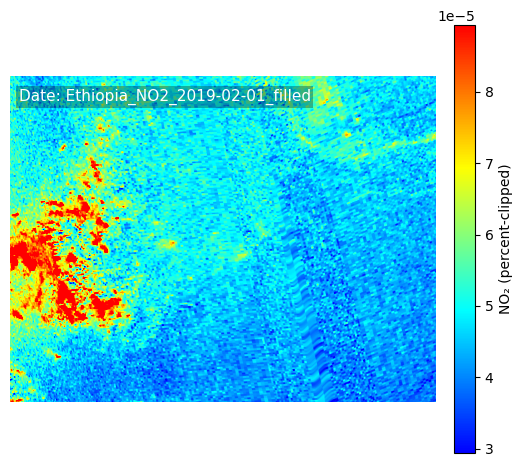

In [11]:
no2_eth_tif_dir= Path("D:\\Projects\\MSc_Group_Project\\no2_economicactivity_gdp\\data\\Ethiopia_NO2_filled")   

generate_animation(no2_eth_tif_dir, out_gif_name="Ethiopia_NO2_Animation", fps = 10)

#### 2) NO2 Distribution in Iraq

Scanning percentiles: 100%|██████████| 200/200 [00:06<00:00, 31.18it/s]


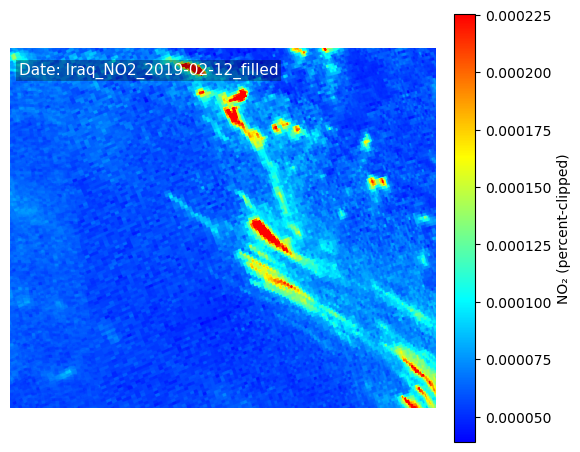

In [12]:
no2_iraq_tif_dir= Path("D:\\Projects\\MSc_Group_Project\\no2_economicactivity_gdp\\data\\Iraq_NO2_filled")   

generate_animation(no2_iraq_tif_dir, out_gif_name="Iraq_NO2_Animation", fps = 10)